# Summer analysis 2023: ndvi+ndmi+marginalization res 10

This notebook joins ndvi (res10), ndmi (res10) and marginalization (res8 to res10 through centroids) and creates categories for NDVI and marg in order to create the following analysis:

Analysis 1: (CSV) Average ndvi and ndmi min, median, mean, max data by marginalization group.

Analysis 2: (MAP, BOXPLOT) Zones that may recieve irrigation within urban spaces and its relation with marginalization. Places without vegetation are discarted.(ndvi without locations with water, marshy surfaces, artificial structures, rocks adn clouds).

Analysis 3: (CSV) From analisis 2, ndmi_diff (humidity variation/conservation) extremes (10%max, 10%min) are located, ploted and exported to csv.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [2]:
city = 'Monterrey'

In [3]:
#Save csvs to output>figures>ndmi_ndmi_marg_bycity?
csv_dataset = True 
#"averagerasterdata_bymarg": csv containing ndvi and ndmi min, mean, median and max, along with the marginalization category
#"ndmi_diffextremes_marg": csv containing the top 10% and bottom 10% ndmi_diff (humidity variation/conservation) related to the marginalization degree.

#Save figures to output>figures>ndmi_ndmi_marg_bycity?
save_plots = True

## Data download

Data download - NDVI

In [4]:
# Downloading NDVI res 10 data
ndvi_schema = 'raster_analysis'
ndvi_folder = 'ndvi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndvi_schema}.{ndvi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndvi_res10.shape)
ndvi_res10.head(2)

(75705, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8a48a204b8f7fff,"POLYGON ((-100.40660 25.79195, -100.40592 25.7...",10,0.131890,0.058109,0.127495,0.194658,0.038599,0.156059,-0.001819,Monterrey
1,8a48a2009baffff,"POLYGON ((-100.28793 25.68539, -100.28725 25.6...",10,0.042693,0.030745,0.043859,0.081985,-0.016446,0.098431,-0.000583,Monterrey


Data download - NDMI

In [5]:
# Downloading NDMI res 10 data
ndmi_schema = 'raster_analysis'
ndmi_folder = 'ndmi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndmi_schema}.{ndmi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndmi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndmi_res10.shape)
ndmi_res10.head(2)

(75705, 11)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,city
0,8a48a20e136ffff,"POLYGON ((-100.25983 25.75116, -100.25915 25.7...",10,-0.001140,0.080293,-0.019805,0.160764,-0.043485,0.204249,0.000001,Monterrey
1,8a48a20e135ffff,"POLYGON ((-100.25779 25.75242, -100.25711 25.7...",10,0.006627,0.081103,-0.007026,0.174346,-0.048579,0.222925,-0.000300,Monterrey


Data download - Municipalities (in order to download marginalization)

In [6]:
mun_schema = 'metropolis'
mun_table = 'metro_gdf'

query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(18, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,19001,19,001,Abasolo,"POLYGON ((-100.39267 25.98715, -100.39224 25.9...",Monterrey
1,19006,19,006,Apodaca,"POLYGON ((-100.24794 25.86462, -100.24672 25.8...",Monterrey


Data download - Marginalization

In [7]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())
cvegeo_list

['19001',
 '19006',
 '19009',
 '19010',
 '19012',
 '19018',
 '19019',
 '19021',
 '19025',
 '19026',
 '19031',
 '19039',
 '19041',
 '19045',
 '19046',
 '19047',
 '19048',
 '19049']

In [8]:
# donwload hexagons with marg data
hex_marg = gpd.GeoDataFrame()
marg_table = 'hex_bins_marg_2020'
marg_schema = 'censo'


# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {marg_schema}.{marg_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_marg = pd.concat([hex_marg, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_marg.shape)
hex_marg.head(2)

(1463, 17)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,"POLYGON ((-100.38026 25.93877, -100.38069 25.9...",8848a23881fffff,19001,250.11478,1.507139,6.775771,0.155156,0.077578,0.077578,0.077578,0.0,0.659412,15.438009,1.512770,9.580874,123.461212,0.964433
1,"POLYGON ((-100.38588 25.94625, -100.38631 25.9...",8848a23883fffff,19001,487.42150,3.485196,33.948074,3.441633,0.081661,0.081661,0.081661,0.0,1.016450,87.389890,8.739015,55.745712,123.066629,0.961350


## Data treatment

### Data treatment - Bring marginalization data (res8) to ndvi (res10)

Find ndvi centroids in order to intersect res10 info with a single res8 hex

In [9]:
#Find centroids
ndvi_res10_calc = ndvi_res10.to_crs("EPSG:6372")
centroids = ndvi_res10_calc.centroid
centroids = centroids.to_crs("EPSG:4326")

#Turn into gdf
centroids_gdf = gpd.GeoDataFrame(centroids)
centroids_gdf = centroids_gdf.rename(columns={0:'geometry'})

#Review result
print(centroids_gdf.shape)
centroids_gdf.head(2)

(75705, 1)


,geometry
0,POINT (-100.40666 25.79270)
1,POINT (-100.28799 25.68614)


Intersect centroids with orginal ndvi data to keep hex_id data

In [10]:
centroids_hexid = gpd.overlay(centroids_gdf,ndvi_res10,keep_geom_type=True)

columns_tokeep = ['hex_id','geometry']
centroids_hexid = centroids_hexid[columns_tokeep]

#Review result
print(centroids_hexid.shape)
centroids_hexid.head(2)

(75705, 2)


,hex_id,geometry
0,8a48a204b8f7fff,POINT (-100.40666 25.79270)
1,8a48a2009baffff,POINT (-100.28799 25.68614)


Intersect centroids with marginalization data

In [11]:
centroids_marg = gpd.overlay(centroids_hexid,hex_marg,keep_geom_type=True)

columns_tokeep = ['hex_id','pobtot','im_2020','imn_2020']
centroids_marg = centroids_marg[columns_tokeep]

#Review result
print(centroids_marg.shape)
centroids_marg.head(2)

(71687, 4)


,hex_id,pobtot,im_2020,imn_2020
0,8a48a204b8f7fff,8722.8,120.210189,0.939037
1,8a48a204b997fff,8722.8,120.210189,0.939037


Merge centroids_marg back with res10 geometry

In [12]:
ndvi_marg = pd.merge(ndvi_res10,centroids_marg, on='hex_id')

#Review result
print(ndvi_marg.shape)
ndvi_marg.head(2)

(71687, 14)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,pobtot,im_2020,imn_2020
0,8a48a204b8f7fff,"POLYGON ((-100.40660 25.79195, -100.40592 25.7...",10,0.131890,0.058109,0.127495,0.194658,0.038599,0.156059,-0.001819,Monterrey,8722.800,120.210189,0.939037
1,8a48a2009baffff,"POLYGON ((-100.28793 25.68539, -100.28725 25.6...",10,0.042693,0.030745,0.043859,0.081985,-0.016446,0.098431,-0.000583,Monterrey,6611.046,123.178507,0.962224


### Data treatment - Merge NDVI_MARG with NDMI

In [13]:
ndmi_res10_clean = ndmi_res10.drop(columns=['geometry','res','city'])
ndvi_ndmi_marg = ndvi_marg.merge(ndmi_res10_clean, left_on='hex_id', right_on='hex_id')

#Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(71687, 21)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,pobtot,im_2020,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend
0,8a48a204b8f7fff,"POLYGON ((-100.40660 25.79195, -100.40592 25.7...",10,0.131890,0.058109,0.127495,0.194658,0.038599,0.156059,-0.001819,...,8722.800,120.210189,0.939037,0.010376,0.060534,-0.000959,0.148012,-0.040800,0.188812,-0.000670
1,8a48a2009baffff,"POLYGON ((-100.28793 25.68539, -100.28725 25.6...",10,0.042693,0.030745,0.043859,0.081985,-0.016446,0.098431,-0.000583,...,6611.046,123.178507,0.962224,-0.005838,0.089441,-0.025530,0.186137,-0.063574,0.249711,-0.000254


### Data treatment - Create data categories

Data treatment - Creating vegetation categories

In [14]:
# Creating vegetation categories
ndvi_ndmi_marg['ndvi_median_rango'] = np.nan
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.4 )&
             (ndvi_ndmi_marg.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.2)&
             (ndvi_ndmi_marg.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.1)&
             (ndvi_ndmi_marg.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'

# Ordering data
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_ndmi_marg['ndvi_median_rango'] = pd.Categorical(ndvi_ndmi_marg['ndvi_median_rango'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(71687, 22)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,im_2020,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango
0,8a48a204b8f7fff,"POLYGON ((-100.40660 25.79195, -100.40592 25.7...",10,0.131890,0.058109,0.127495,0.194658,0.038599,0.156059,-0.001819,...,120.210189,0.939037,0.010376,0.060534,-0.000959,0.148012,-0.040800,0.188812,-0.000670,Suelo
1,8a48a2009baffff,"POLYGON ((-100.28793 25.68539, -100.28725 25.6...",10,0.042693,0.030745,0.043859,0.081985,-0.016446,0.098431,-0.000583,...,123.178507,0.962224,-0.005838,0.089441,-0.025530,0.186137,-0.063574,0.249711,-0.000254,Suelo artificial/Agua/Piedra


Reviewing ndvi proportions

In [15]:
ndviproportions = ndvi_ndmi_marg.groupby('ndvi_median_rango').count()

columns_tokeep = ['hex_id']
ndviproportions = ndviproportions[columns_tokeep]

ndviproportions = ndviproportions.rename(columns={'hex_id':'count'})
ndviproportions['%'] = ndviproportions['count'].apply(lambda x: (x/(ndviproportions['count'].sum()))*100)

ndviproportions

,count,%
ndvi_median_rango,,
Suelo artificial/Agua/Piedra,18883,26.340899
Suelo,21051,29.365157
Mínima densidad vegetal,22138,30.881471
Moderada densidad vegetal,8919,12.441586
Alta densidad vegetal,696,0.970887


Data treatment - Creating marginalization categories

In [16]:
ndvi_ndmi_marg['Grado_Marg'] = np.nan
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.imn_2020>=0.966338 , 'Grado_Marg'] = 'Muy bajo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.946436 )&
             (ndvi_ndmi_marg.imn_2020<0.966338), 'Grado_Marg'] = 'Bajo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.926536)&
             (ndvi_ndmi_marg.imn_2020<0.946436), 'Grado_Marg'] = 'Medio'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.8999)&
             (ndvi_ndmi_marg.imn_2020<0.926536), 'Grado_Marg'] = 'Alto'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020<0.8999), 'Grado_Marg'] = 'Muy Alto'

categories = ['Muy Alto', 'Alto', 'Medio', 'Bajo', 'Muy bajo']
ndvi_ndmi_marg['Grado_Marg'] = pd.Categorical(ndvi_ndmi_marg['Grado_Marg'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(71687, 23)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg
0,8a48a204b8f7fff,"POLYGON ((-100.40660 25.79195, -100.40592 25.7...",10,0.131890,0.058109,0.127495,0.194658,0.038599,0.156059,-0.001819,...,0.939037,0.010376,0.060534,-0.000959,0.148012,-0.040800,0.188812,-0.000670,Suelo,Medio
1,8a48a2009baffff,"POLYGON ((-100.28793 25.68539, -100.28725 25.6...",10,0.042693,0.030745,0.043859,0.081985,-0.016446,0.098431,-0.000583,...,0.962224,-0.005838,0.089441,-0.025530,0.186137,-0.063574,0.249711,-0.000254,Suelo artificial/Agua/Piedra,Bajo


Reviewing marg proportions

In [17]:
margproportions = ndvi_ndmi_marg.groupby('Grado_Marg').count()

columns_tokeep = ['hex_id']
margproportions = margproportions[columns_tokeep]

margproportions = margproportions.rename(columns={'hex_id':'count'})
margproportions['%'] = margproportions['count'].apply(lambda x: (x/(margproportions['count'].sum()))*100)

margproportions

,count,%
Grado_Marg,,
Muy Alto,343,0.478469
Alto,1127,1.572112
Medio,9947,13.875598
Bajo,30870,43.062201
Muy bajo,29400,41.011620


## Analysis 1 - Average min, mean, median, max data by marginalization group

In [18]:
# Group by calculating min, mean, median and max ndvi and ndmi for each marginalization group
marginalization_behaviour = ndvi_ndmi_marg.groupby('Grado_Marg').agg({'ndvi_min':np.mean,'ndvi_mean':np.mean,'ndvi_median':np.mean,'ndvi_max':np.mean,
                                                                      'ndmi_min':np.mean,'ndmi_mean':np.mean,'ndmi_median':np.mean,'ndmi_max':np.mean})

# Calculate the summary statistics across columns
summary_df = pd.DataFrame({
    'ndvi_min': pd.Series(ndvi_ndmi_marg['ndvi_min'].mean(), index=['Todos los hex']),
    'ndvi_mean': pd.Series(ndvi_ndmi_marg['ndvi_mean'].mean(), index=['Todos los hex']),
    'ndvi_median': pd.Series(ndvi_ndmi_marg['ndvi_median'].mean(), index=['Todos los hex']),
    'ndvi_max': pd.Series(ndvi_ndmi_marg['ndvi_max'].mean(), index=['Todos los hex']),
    'ndmi_min': pd.Series(ndvi_ndmi_marg['ndmi_min'].mean(), index=['Todos los hex']),
    'ndmi_mean': pd.Series(ndvi_ndmi_marg['ndmi_mean'].mean(), index=['Todos los hex']),
    'ndmi_median': pd.Series(ndvi_ndmi_marg['ndmi_median'].mean(), index=['Todos los hex']),
    'ndmi_max': pd.Series(ndvi_ndmi_marg['ndmi_max'].mean(), index=['Todos los hex'])
})

# Append the summary row to the original dataframe
marginalization_behaviour_with_summary = pd.concat([marginalization_behaviour, summary_df])

# Rename columns to clarify that they represent the mean values of each category
marginalization_behaviour_with_summary.rename(columns={
    'ndvi_min': 'avg ndvi_min',
    'ndvi_mean': 'avg ndvi_mean',
    'ndvi_median': 'avg ndvi_median',
    'ndvi_max': 'avg ndvi_max',
    'ndmi_min': 'avg ndmi_min',
    'ndmi_mean': 'avg ndmi_mean',
    'ndmi_median': 'avg ndmi_median',
    'ndmi_max': 'avg ndmi_max'},inplace=True)

marginalization_behaviour_with_summary

,avg ndvi_min,avg ndvi_mean,avg ndvi_median,avg ndvi_max,avg ndmi_min,avg ndmi_mean,avg ndmi_median,avg ndmi_max
Muy Alto,0.039999,0.209018,0.198683,0.376208,-0.108660,-0.009527,-0.022911,0.165715
Alto,0.037491,0.279495,0.278103,0.470924,-0.104079,0.021025,0.011448,0.211836
Medio,0.045605,0.228938,0.227457,0.377378,-0.084530,0.014559,0.000836,0.193175
Bajo,0.038042,0.207576,0.205659,0.342798,-0.084312,0.010229,-0.004077,0.190418
Muy bajo,0.039758,0.212049,0.214198,0.341964,-0.061363,0.028665,0.017070,0.198022
Todos los hex,0.039796,0.213512,0.213291,0.349428,-0.075358,0.018466,0.005431,0.194138


In [19]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = marginalization_behaviour_with_summary.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../output//figures/ndvi_ndmi_marg_bycity/{}/averagerasterdata_bymarg_{}.csv".format(city.lower(),city.lower()))

(6, 8)


## Analysis 2 - Zones that may recieve irrigation within urban spaces (ndmi_diff analysis) and its relation with marginalization

### Anlysis 2 Data treatment - Filter for places with vegetation

NDVI filtering for places with vegetation

In [20]:
#Keeping High-moderate-minimal vegetation density
data_withveg = ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median_rango == 'Alta densidad vegetal') |
                   (ndvi_ndmi_marg.ndvi_median_rango == 'Moderada densidad vegetal')|
                   (ndvi_ndmi_marg.ndvi_median_rango == 'Mínima densidad vegetal')]

#Reviewing process
print(data_withveg.shape)
data_withveg.head(2)

(31753, 23)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg
16,8a48a206a56ffff,"POLYGON ((-100.40751 25.72571, -100.40683 25.7...",10,0.289170,0.146786,0.297757,0.462017,0.050709,0.411308,-0.002898,...,0.982819,0.060932,0.075308,0.061080,0.205100,-0.030806,0.235906,-0.001303,Mínima densidad vegetal,Muy bajo
17,8a48a206a41ffff,"POLYGON ((-100.40202 25.72831, -100.40134 25.7...",10,0.204472,0.112723,0.218439,0.333887,0.008106,0.325781,-0.002206,...,0.982819,0.038269,0.068641,0.031179,0.168802,-0.042848,0.211649,-0.000746,Mínima densidad vegetal,Muy bajo


Visual correlation analyisis

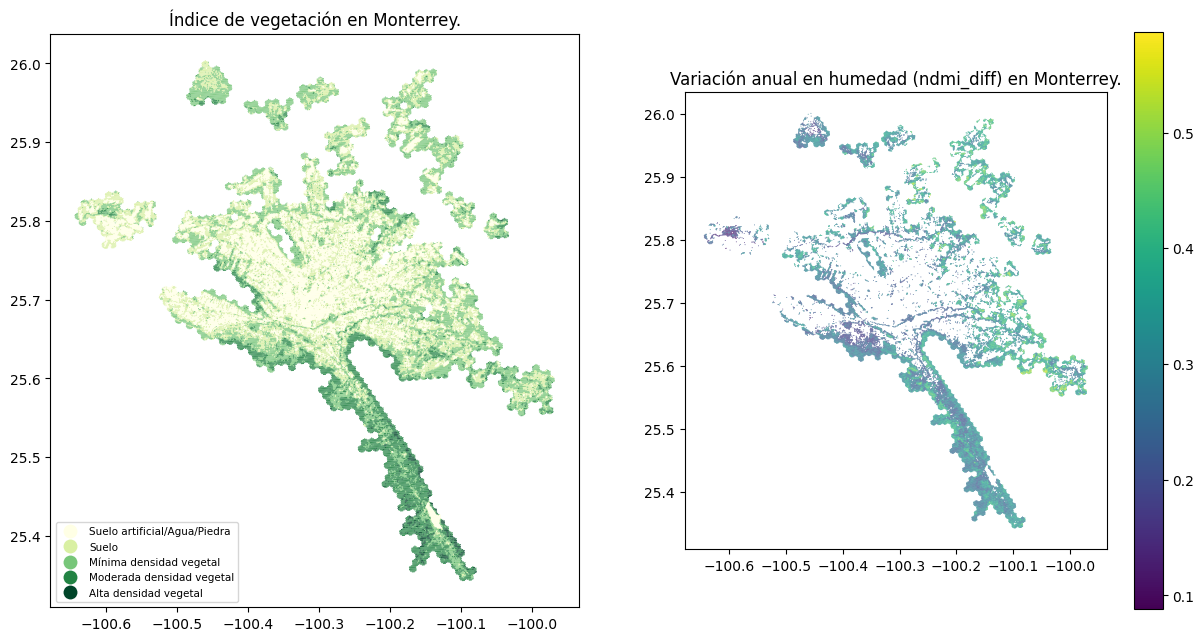

In [31]:
fig, ax = plt.subplots(1,2,figsize=(15,7.5))

#---------- Ax 0 ----------
ax[0].set_title('Índice de vegetación en {}.'.format(city))
ndvi_ndmi_marg.plot('ndvi_median_rango', 'YlGn', ax=ax[0],legend=True,
                    legend_kwds={'fontsize':7.5,'loc':'lower left'})

#---------- Ax 1 ----------
ax[1].set_title('Variación anual en humedad (ndmi_diff) en {}.'.format(city))
data_withveg.plot('ndmi_diff', 'viridis', ax=ax[1], legend=True)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmidiff_{}.svg".format(city.lower(),city.lower()))

### Analysis 2 Data analysis - Boxplot

In [22]:
boxplot_gdf = ndvi_ndmi_marg.copy()
boxplot_gdf = boxplot_gdf.sort_values('Grado_Marg')
boxplot_gdf.loc[boxplot_gdf.Grado_Marg.isna()]

,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg


      index  Grado_Marg
4  Muy Alto         343
3      Alto        1127
2     Medio        9947
0      Bajo       30870
1  Muy bajo       29400


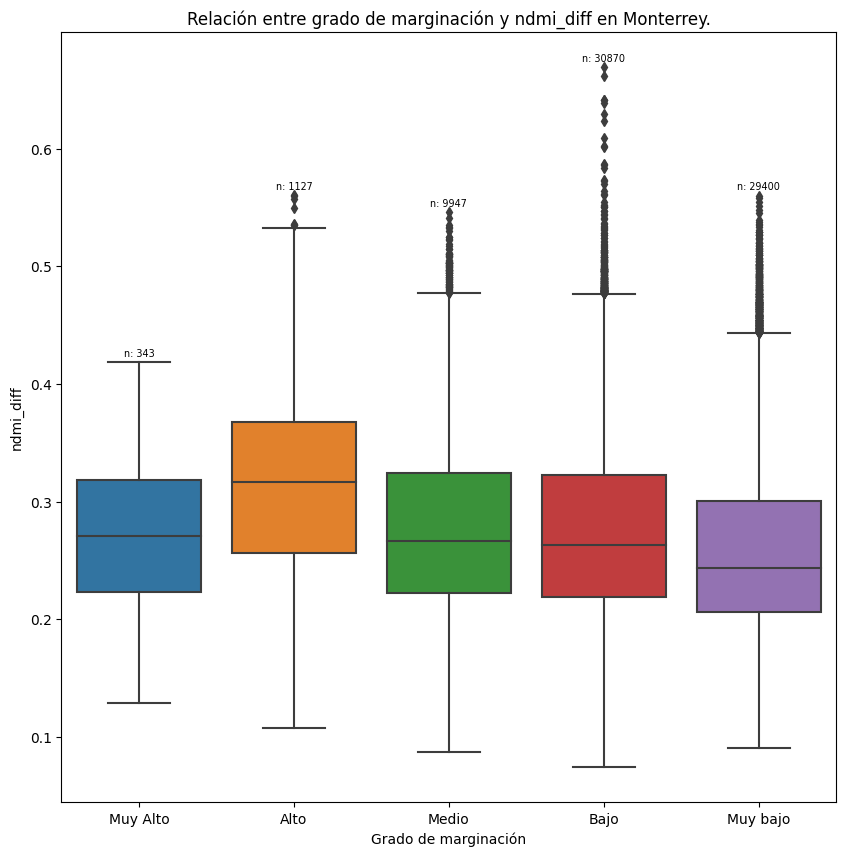

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

#---------Plot
sns.boxplot(x=np.array(boxplot_gdf.Grado_Marg) , 
            y=np.array(boxplot_gdf.ndmi_diff), 
            ax=ax)

#---------Format
plt.title('Relación entre grado de marginación y ndmi_diff en {}.'.format(city))
plt.xlabel('Grado de marginación')
plt.ylabel('ndmi_diff')

# ------------------------------------------- Add number of hex per marginalization group -------------------------------------------

#---------Position
#Calculate max of each Marginalization group to position number of observations above each boxplot
maxs = boxplot_gdf.groupby(['Grado_Marg'])['ndmi_diff'].max()
num_maxs = maxs.values
#Drop NaNs
num_maxs = num_maxs[~np.isnan(num_maxs)]

#---------Count
#Calculate number of observations per group
obs = boxplot_gdf['Grado_Marg'].value_counts()
obs = obs.reset_index()
obs = obs.sort_values('index')
print(obs)
#Drop Ceros by turning them to nans
obs = obs['Grado_Marg'].apply(lambda x: np.nan if x==0 else x)
obs = obs[~np.isnan(obs)]

num_obs = obs.values
num_obs = [str(x) for x in num_obs.tolist()]
num_obs = ["n: " + i for i in num_obs]

#---------Add it to the plot
pos = range(len(num_obs))
for tick,label in zip(pos,ax.get_xticklabels()):
    #ax.text(x,y,text)
    ax.text(pos[tick],
            num_maxs[tick] + 0.005,
            num_obs[tick],
            horizontalalignment='center',
            size='x-small',
            color='black')
# ------------------------------------------- ------------------------------------------- -------------------------------------------

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmidiff_marg_boxplot_{}.svg".format(city.lower(),city.lower()))

## Analysis 3 - ndmi_diff (humidity variation/conservation) extremes (10%max, 10%min)

### Analysis 3 Data treatment - Find mins and maxs ndmi_diff

Find 10% mins and 10% maxs

In [24]:
# Finding len of 10% of data
tenpercent = int(len(data_withveg)/10)

#Finding smallest and largest ndmi_diff
ndmi_diff_mins = data_withveg.nsmallest(tenpercent,'ndmi_diff')
ndmi_diff_maxs = data_withveg.nlargest(tenpercent,'ndmi_diff')

Create maxs and mins category

In [25]:
ndmi_diff_mins['ndmi_diff_cat'] = '10%_mins'
ndmi_diff_maxs['ndmi_diff_cat'] = '10%_maxs'

ndmi_diff_extremes = pd.concat([ndmi_diff_mins, ndmi_diff_maxs])

print(ndmi_diff_extremes.shape)
ndmi_diff_extremes.head(2)

(6350, 24)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg,ndmi_diff_cat
29023,8a48a232d487fff,"POLYGON ((-100.59590 25.80956, -100.59522 25.8...",10,0.191708,0.073744,0.204331,0.262959,0.058688,0.204271,-0.001639,...,0.018330,0.029099,0.014346,0.067211,-0.020528,0.087739,-0.000407,Mínima densidad vegetal,Bajo,10%_mins
28714,8a48a2328867fff,"POLYGON ((-100.59306 25.80975, -100.59238 25.8...",10,0.277845,0.099322,0.317461,0.358961,0.088346,0.270615,-0.001141,...,0.053009,0.032399,0.049802,0.092337,0.004366,0.087971,-0.000991,Mínima densidad vegetal,Bajo,10%_mins


Plot data to get a visual

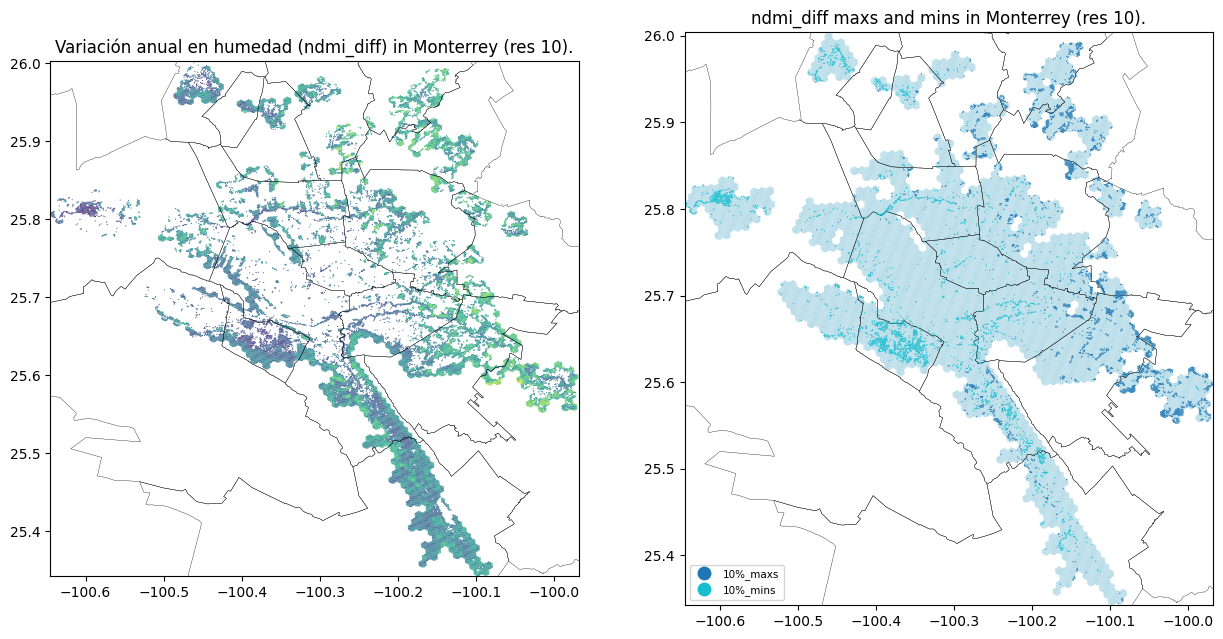

In [26]:
#Create figure
fig,ax = plt.subplots(1,2,figsize=(15,7.5))

#--------- First ax ---------
#Plotting ndmi_diff
data_withveg.plot('ndmi_diff', 'viridis', ax=ax[0], zorder = 0)
#Plot municipalities
mun_gdf.plot(facecolor="none", edgecolor='black', lw=0.25, ax=ax[0], zorder = 1)

##---------Format
ax[0].set_title('Variación anual en humedad (ndmi_diff) in {} (res 10).'.format(city))

# Set the extents of the plot to match the base hexes data
ax[0].set_xlim(data_withveg.total_bounds[0], data_withveg.total_bounds[2])
ax[0].set_ylim(data_withveg.total_bounds[1], data_withveg.total_bounds[3])


#--------- Second ax ---------
#Plot base hexes
ndvi_ndmi_marg.plot(color = 'lightblue',ax=ax[1], zorder = 0)
#Plot municipalities
mun_gdf.plot(facecolor="none", edgecolor='black', lw=0.25, ax=ax[1], zorder = 1)
#Plot extremes data
ndmi_diff_extremes.plot('ndmi_diff_cat',ax=ax[1],zorder = 2, 
                        legend=True, legend_kwds={'fontsize':7.5,'loc':'lower left'})

##---------Format
ax[1].set_title('ndmi_diff maxs and mins in {} (res 10).'.format(city))

# Set the extents of the plot to match the base hexes data
ax[1].set_xlim(ndvi_ndmi_marg.total_bounds[0], ndvi_ndmi_marg.total_bounds[2])
ax[1].set_ylim(ndvi_ndmi_marg.total_bounds[1], ndvi_ndmi_marg.total_bounds[3])
#agregar pad

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmidiff_minsandmaxs_{}.svg".format(city.lower(),city.lower()))

### Analysis 3 Data analysis - San Pedro edition

In [27]:
#San Pedro
#sanpedro = mun_gdf.loc[(mun_gdf.NOMGEO == 'San Pedro Garza García')]
#sanpedro = sanpedro.set_crs("EPSG:4326")

# % de hexs de ndmi_diff que se encuentran en San Pedro
#sanpedro_ndmidiff_hexs = gpd.overlay(data_withveg,sanpedro,keep_geom_type=True)
#print(sanpedro_ndmidiff_hexs.shape)
 
# % de hexs dentro del 10% que conserva más humedad que se encuentran en San Pedro
#sanpedro_ndmidiff_mins = gpd.overlay(ndmi_diff_extremes,sanpedro,keep_geom_type=True)
#sanpedro_proportions = sanpedro_ndmidiff_mins.groupby('ndmi_diff_cat').count()
#sanpedro_proportions

### Analysis 3 Data analysis - Clean data and export to csv

Clean gdf

In [28]:
columns_tokeep = ['hex_id','res','ndmi_diff','ndmi_diff_cat','im_2020','imn_2020','Grado_Marg','city','geometry']
ndmi_diff_extremes_c = ndmi_diff_extremes[columns_tokeep]
                  
#Review result
print(ndmi_diff_extremes_c.shape)
ndmi_diff_extremes_c.head(2)

(6350, 9)


,hex_id,res,ndmi_diff,ndmi_diff_cat,im_2020,imn_2020,Grado_Marg,city,geometry
29023,8a48a232d487fff,10,0.087739,10%_mins,121.271892,0.947331,Bajo,Monterrey,"POLYGON ((-100.59590 25.80956, -100.59522 25.8..."
28714,8a48a2328867fff,10,0.087971,10%_mins,122.542784,0.957258,Bajo,Monterrey,"POLYGON ((-100.59306 25.80975, -100.59238 25.8..."


Data linear transformation in order to produce desired 3D map

In [29]:
#Linear intepolation data
x1 = ndmi_diff_extremes_c['ndmi_diff'].max()
y1 = ndmi_diff_extremes_c['ndmi_diff'].min()

x2 = ndmi_diff_extremes_c['ndmi_diff'].min()
y2 = ndmi_diff_extremes_c['ndmi_diff'].max()

m = (y2-y1)/(x2-x1)
b = y1-m*x1

# Convert all ndmi_diff to its opossite value in that linear interpolation (y=mx+b)
ndmi_diff_extremes_c['ndmi_diff_opossite'] = ndmi_diff_extremes_c['ndmi_diff'].apply(lambda x: m*x+b)

#Review result
print(ndmi_diff_extremes_c.shape)
ndmi_diff_extremes_c.head(2)

(6350, 10)


/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,hex_id,res,ndmi_diff,ndmi_diff_cat,im_2020,imn_2020,Grado_Marg,city,geometry,ndmi_diff_opossite
29023,8a48a232d487fff,10,0.087739,10%_mins,121.271892,0.947331,Bajo,Monterrey,"POLYGON ((-100.59590 25.80956, -100.59522 25.8...",0.586953
28714,8a48a2328867fff,10,0.087971,10%_mins,122.542784,0.957258,Bajo,Monterrey,"POLYGON ((-100.59306 25.80975, -100.59238 25.8...",0.586721


Export to csv

In [30]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = ndmi_diff_extremes_c.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../output//figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmi_diffextremes_marg_{}.csv".format(city.lower(),city.lower()))

(6350, 10)
